In [2]:
import pandas as pd
import numpy as np
import folium
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, Normalize
import matplotlib.cm as cm

# Comparative Result

In [3]:
import pandas as pd

# Define the file path and sheet name
excel_file_path = 'result/Result.xlsx'
sheet_name = 'organized_comp'  # Replace with the name of the sheet you want to read

# Read the specific sheet into a DataFrame
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Display the DataFrame
df.head()

,track_id,replication,fold_i,min_pretrain_val_loss,pretrain_time,train_loss,min_val_a_loss,train_time,test_a_MAE,test_a_MSE,...,step_10.RMSE,step_10.MAPE,step_11.MAE,step_11.MSE,step_11.RMSE,step_11.MAPE,step_12.MAE,step_12.MSE,step_12.RMSE,step_12.MAPE
0,9001.0,1.0,0.0,NaN,NaN,3.547509,3.246358,419.471994,3.931429,56.052681,...,8.786176,14.549507,4.754375,81.906845,9.050241,15.069665,4.928721,87.298012,9.343341,15.788284
1,9001.0,1.0,1.0,NaN,NaN,4.254870,3.417422,223.987143,4.052934,58.075500,...,8.754848,13.753571,4.898371,82.180054,9.065322,14.262545,5.057129,87.181702,9.337114,14.928235
2,9001.0,1.0,2.0,NaN,NaN,3.705166,3.425574,356.078227,4.282536,61.527081,...,9.223530,15.293110,5.230923,90.667419,9.521944,15.881160,5.501930,98.212173,9.910206,16.809004
3,9001.0,1.0,3.0,NaN,NaN,4.219881,3.371595,223.767159,4.041922,59.823223,...,8.879968,13.243299,4.833441,84.815239,9.209519,13.674585,5.013641,89.837906,9.478286,14.313650
4,9001.0,2.0,0.0,NaN,NaN,3.460366,3.245462,488.827823,4.241012,67.073860,...,9.803694,17.426811,5.281172,102.045883,10.101776,18.062880,5.454171,107.587151,10.372422,18.701576


In [4]:
from scipy.stats import ttest_ind

mean_std_df = df.groupby('track_id')['test_a_MAE'].agg(['mean', 'std']).reset_index()

# Round the mean and standard deviation to four decimal places
mean_std_df['mean'] = mean_std_df['mean'].round(4)
mean_std_df['std'] = mean_std_df['std'].round(4)

print("Mean and standard deviation for each track_id:")
print(mean_std_df)

# Extract the 'test_a_MAE' values for track_id 9003 and 9001
track_9004 = df[df['track_id'] == 9004]['test_a_MAE']
track_9001 = df[df['track_id'] == 9001]['test_a_MAE']

# Calculate the p-value using a t-test
t_stat, p_value = ttest_ind(track_9004, track_9001, equal_var=False)  # Use equal_var=False for Welch's t-test

print(f"\nP-value for the combination of track_id 9004 and 9001: {p_value}")

Mean and standard deviation for each track_id:
    track_id    mean     std
0     9001.0  4.0939  0.1322
1     9002.0  4.0860  0.2433
2     9004.0  3.9557  0.2409
3     9005.0  3.7046  0.1729
4     9006.0  3.4355  0.0808
5     9007.0  3.3650  0.0914
6     9008.0  2.3688  0.0845
7     9009.0  2.3268  0.0560
8     9010.0  2.2815  0.0573
9     9011.0  3.3236  0.0520
10    9012.0  3.3720  0.0729
11    9014.0  3.4331  0.0884
12    9015.0  3.4240  0.1227
13    9016.0  3.5154  0.1152
14    9017.0  3.7668  0.1077
15    9021.0  3.3812  0.1613
16    9022.0  3.3178  0.0760
17    9023.0  3.3714  0.0964
18    9024.0  3.2818  0.1134
19    9025.0  3.2074  0.1117

P-value for the combination of track_id 9004 and 9001: 0.032120870274562396


In [5]:
track_combinations = [(9002, 9001), (9004, 9001), (9006, 9005), (9007, 9005), (9010, 9008), (9010, 9009)]

# Calculate and print the p-value for each combination
for track1, track2 in track_combinations:
    track1_values = df[df['track_id'] == track1]['test_a_MAE']
    track2_values = df[df['track_id'] == track2]['test_a_MAE']
    
    # Calculate the p-value using a t-test
    t_stat, p_value = ttest_ind(track1_values, track2_values, equal_var=False)  # Use equal_var=False for Welch's t-test
    
    # Round the p-value to four decimal places
    p_value = round(p_value, 4)
    
    print(f"P-value for the combination of track_id {track1} and {track2}: {p_value}")

P-value for the combination of track_id 9002 and 9001: 0.8991
P-value for the combination of track_id 9004 and 9001: 0.0321
P-value for the combination of track_id 9006 and 9005: 0.0
P-value for the combination of track_id 9007 and 9005: 0.0
P-value for the combination of track_id 9010 and 9008: 0.0005
P-value for the combination of track_id 9010 and 9009: 0.0158


/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_45715/3889928755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


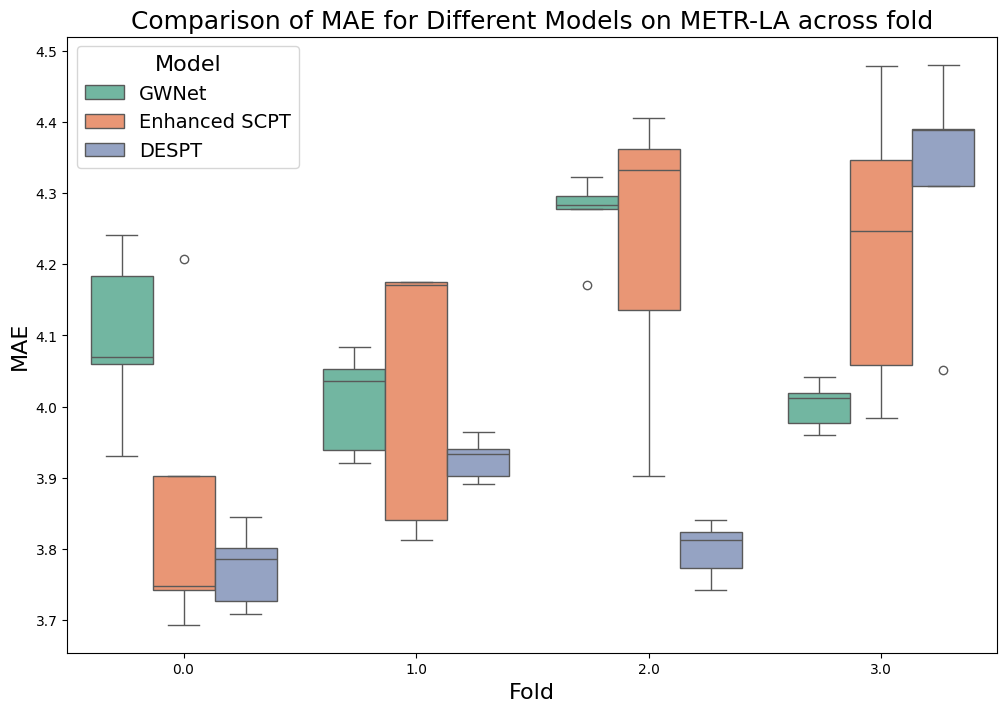

In [6]:
import seaborn as sns

filtered_df = df[df['track_id'].isin([9001, 9002, 9004]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9001: 'GWNet', 9002: 'Enhanced SCPT', 9004: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on METR-LA across fold', fontsize=18)
plt.xlabel('Fold', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_47657/296650802.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


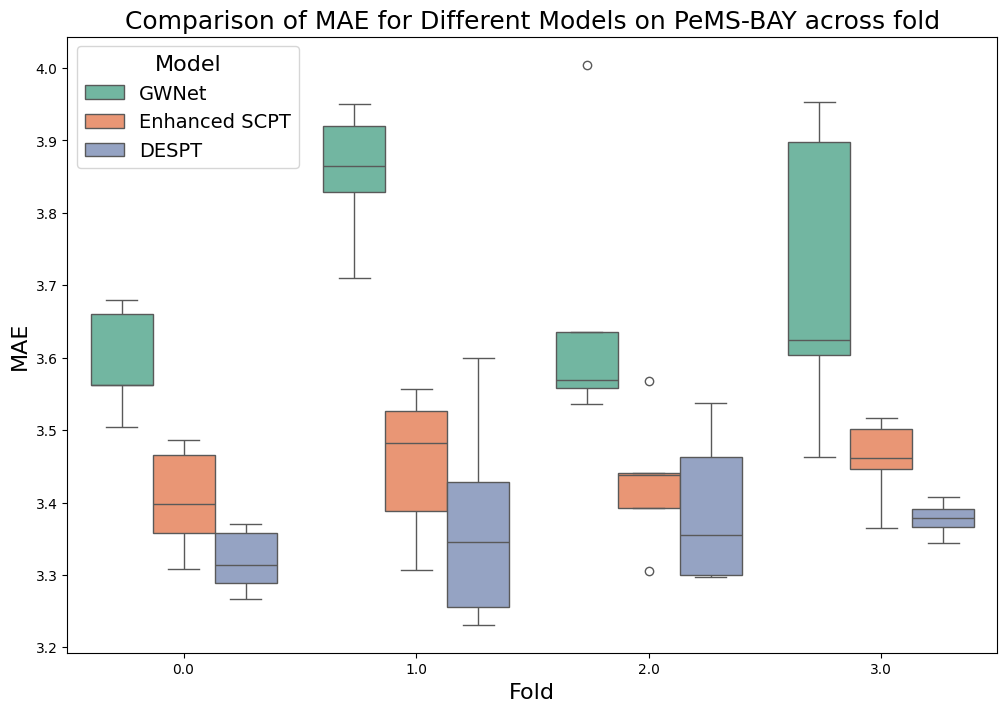

In [7]:
filtered_df = df[df['track_id'].isin([9005, 9006, 9007]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9005: 'GWNet', 9006: 'Enhanced SCPT', 9007: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on PeMS-BAY across fold', fontsize=18)
plt.xlabel('Fold', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_47657/3520749872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


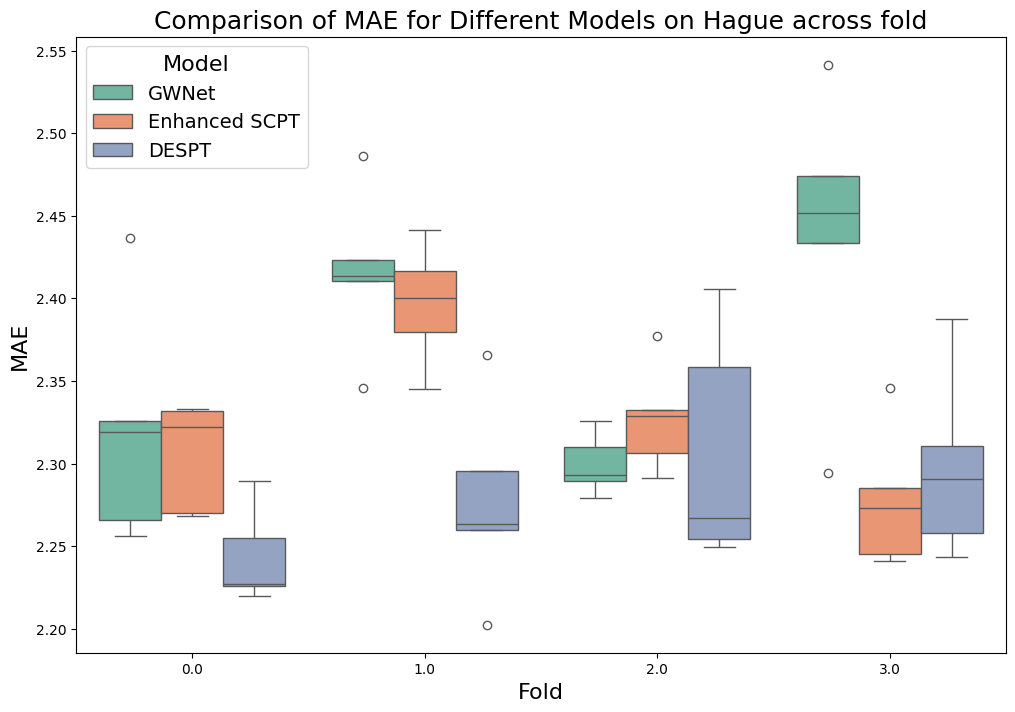

In [9]:
filtered_df = df[df['track_id'].isin([9008, 9009, 9010]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9008: 'GWNet', 9009: 'Enhanced SCPT', 9010: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on Hague across fold', fontsize=18)
plt.xlabel('Fold', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_47657/159161743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


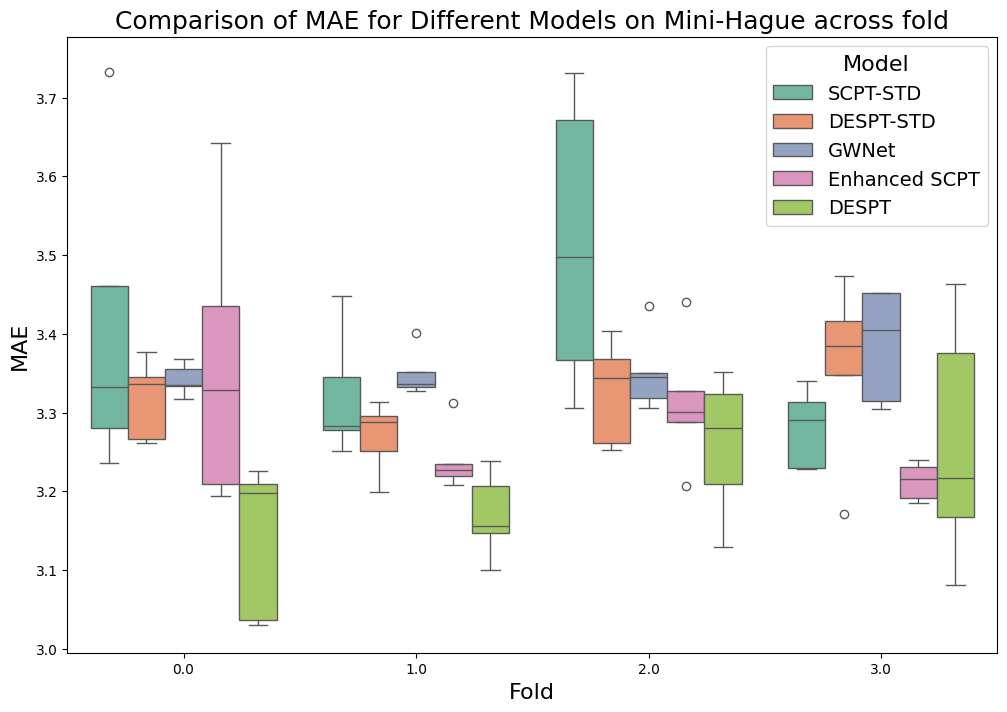

In [10]:
filtered_df = df[df['track_id'].isin([9021, 9022, 9023, 9024, 9025]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9021: 'SCPT-STD', 9022: 'DESPT-STD',9023: 'GWNet',9024: 'Enhanced SCPT' ,9025: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on Mini-Hague across fold', fontsize=18)
plt.xlabel('Fold', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_45715/4160145211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


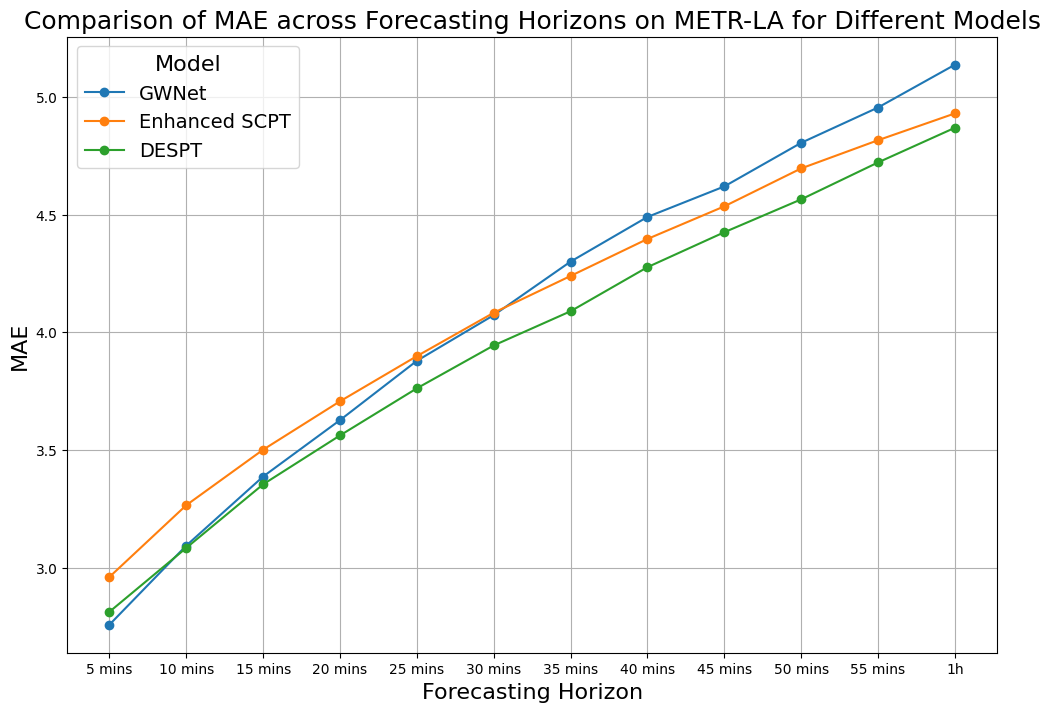

In [7]:
filtered_df = df[df['track_id'].isin([9001, 9002, 9004])]
track_id_labels = {9001: 'GWNet', 9002: 'Enhanced SCPT', 9004: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
steps = [f'step_{i}.MAE' for i in range(1, 13)]
time_labels = ['5 mins', '10 mins', '15 mins', '20 mins', '25 mins', '30 mins', 
               '35 mins', '40 mins', '45 mins', '50 mins', '55 mins', '1h']
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['GWNet', 'Enhanced SCPT', 'DESPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[steps].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Forecasting Horizons on METR-LA for Different Models', fontsize=18)
plt.xlabel('Forecasting Horizon', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.xticks(step_numbers, time_labels)  # No change to the font size
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_45715/2322645235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


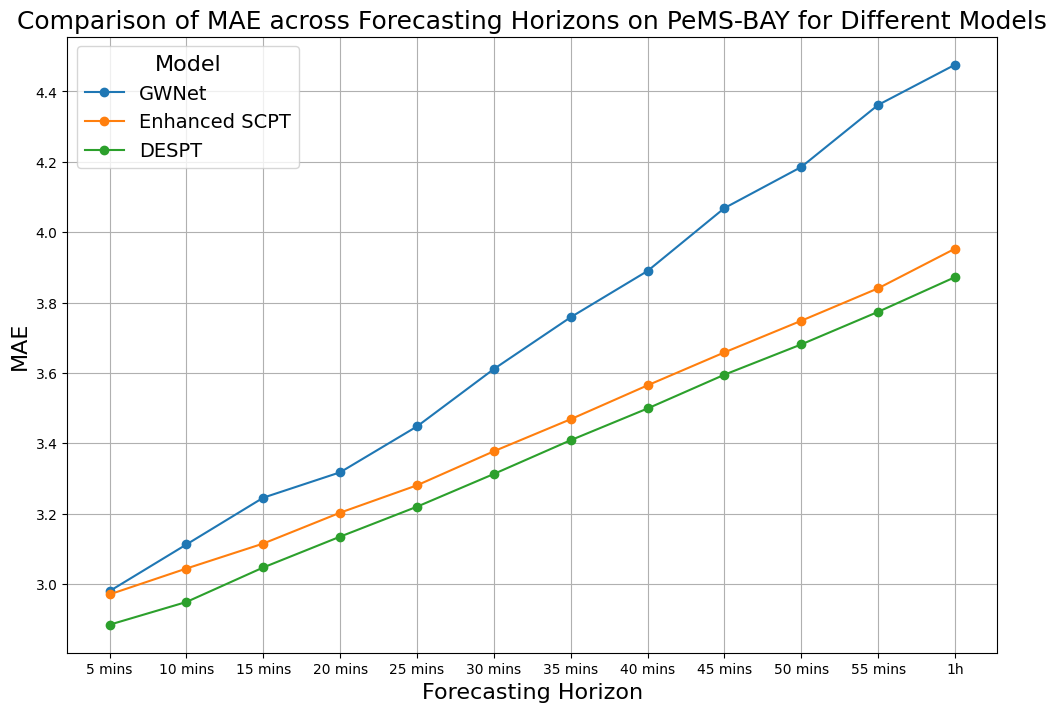

In [8]:
filtered_df = df[df['track_id'].isin([9005, 9006, 9007])]
track_id_labels = {9005: 'GWNet', 9006: 'Enhanced SCPT', 9007: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
forecast_horizons = [f'step_{i}.MAE' for i in range(1, 13)]
time_labels = ['5 mins', '10 mins', '15 mins', '20 mins', '25 mins', '30 mins', 
               '35 mins', '40 mins', '45 mins', '50 mins', '55 mins', '1h']
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['GWNet', 'Enhanced SCPT', 'DESPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[forecast_horizons].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Forecasting Horizons on PeMS-BAY for Different Models', fontsize=18)
plt.xlabel('Forecasting Horizon', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.xticks(step_numbers, time_labels)  # No change to the font size
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_45715/4140505339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


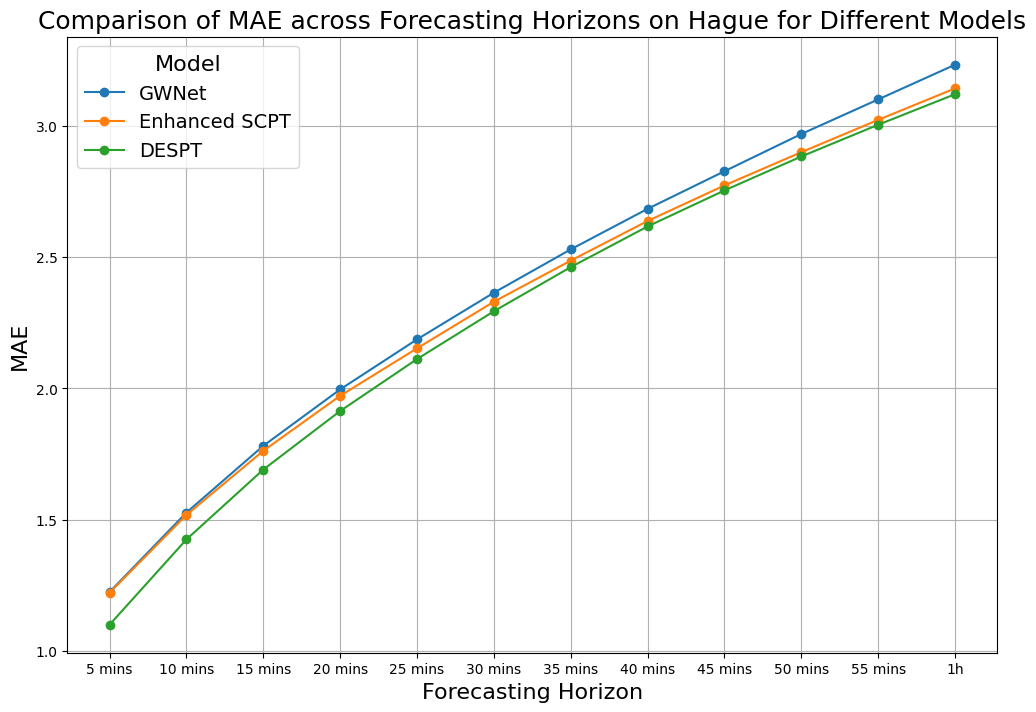

In [9]:
filtered_df = df[df['track_id'].isin([9008, 9009, 9010])]
track_id_labels = {9008: 'GWNet', 9009: 'Enhanced SCPT', 9010: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
forecast_horizons = [f'step_{i}.MAE' for i in range(1, 13)]
time_labels = ['5 mins', '10 mins', '15 mins', '20 mins', '25 mins', '30 mins', 
               '35 mins', '40 mins', '45 mins', '50 mins', '55 mins', '1h']
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['GWNet', 'Enhanced SCPT', 'DESPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[forecast_horizons].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Forecasting Horizons on Hague for Different Models', fontsize=18)
plt.xlabel('Forecasting Horizon', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.xticks(step_numbers, time_labels)  # No change to the font size
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_45715/1110575546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


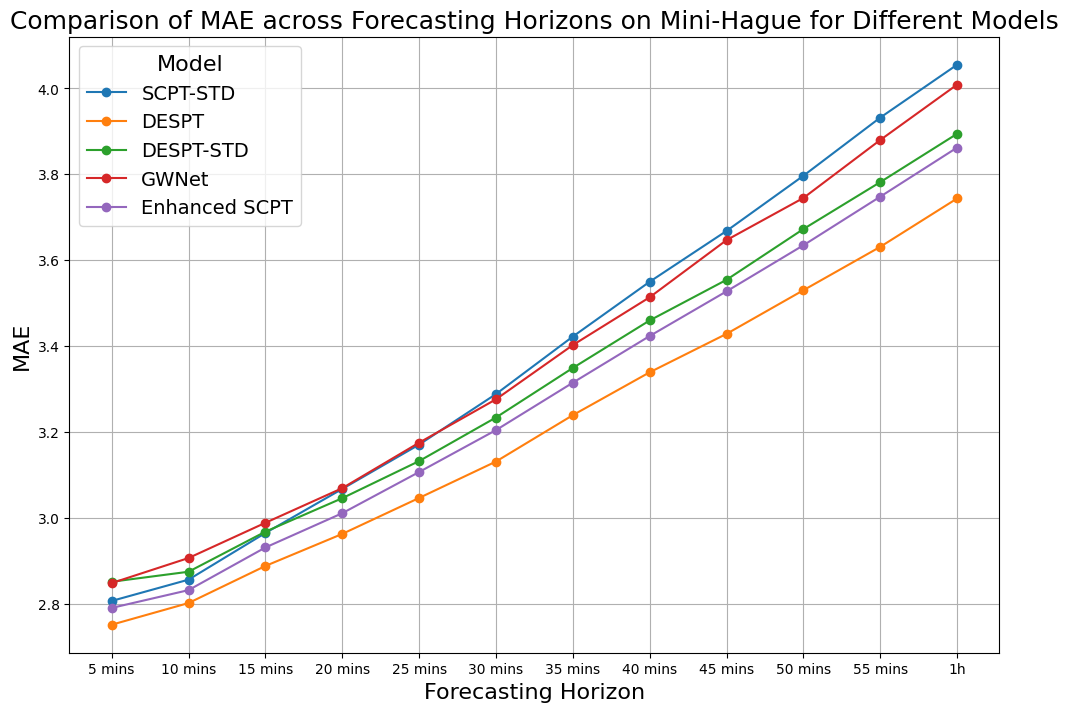

In [10]:
filtered_df = df[df['track_id'].isin([9021, 9022, 9023, 9024, 9025])]
track_id_labels = {9021: 'SCPT-STD', 9022: 'DESPT-STD', 9023: 'GWNet', 9024: 'Enhanced SCPT', 9025: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
forecast_horizons = [f'step_{i}.MAE' for i in range(1, 13)]
time_labels = ['5 mins', '10 mins', '15 mins', '20 mins', '25 mins', '30 mins', 
               '35 mins', '40 mins', '45 mins', '50 mins', '55 mins', '1h']
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['SCPT-STD', 'DESPT', 'DESPT-STD', 'GWNet', 'Enhanced SCPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[forecast_horizons].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Forecasting Horizons on Mini-Hague for Different Models', fontsize=18)
plt.xlabel('Forecasting Horizon', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.xticks(step_numbers, time_labels)  # No change to the font size
plt.legend(title='Model', title_fontsize=16, fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

# Load data

In [23]:
df = pd.read_hdf('data/Hauge/hague_comp_filled.h5')
file_path = 'save/9007_r1_f0_HAGUE_gwnet_TCN_240810-0042/i_tst.txt'
location_df = pd.read_csv('data/Hauge/location_std_comp.csv')

# Read the file
with open(file_path, 'r') as file:
    # Read all lines and convert them to integers
    indexes = np.array([int(line.strip()) for line in file])

In [24]:
filtered_ids = df.columns[indexes]

# Step 4: Set the index of location_df to 'sensor_id' for reindexing
location_df_new = location_df.set_index('sensor_id', inplace=False)

# Step 5: Filter and reindex the location DataFrame to follow the order of filtered_ids
filtered_locations = location_df_new.loc[filtered_ids].reset_index()
filtered_locations

,index,latitude,longitude,trajectory
0,K703-03_1,52.087778,4.280417,T2N
1,K703-05_2,52.087667,4.279889,T2N
2,K206-101,52.061501,4.316314,T2N
3,K561-06_1,52.029861,4.258667,T1N
4,K183-N1,52.076472,4.294778,T2N
5,K159-051,52.084861,4.282722,T2S
6,K503-02_1,52.043667,4.242306,T1S
7,K504-S3,52.042083,4.239861,T1S
8,K561-01_1,52.029889,4.259361,T1S
9,K198-021,52.033389,4.267028,T1N


# Map

In [26]:
import folium
from folium import plugins
from folium.features import DivIcon

# Create the map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Add all locations with blue small dots
for idx, row in location_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=row['sensor_id']
    ).add_to(m)

# Add filtered locations with red small dots
for idx, row in filtered_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=row['index']
    ).add_to(m)

# Add color legend
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 90px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Training Sensors &nbsp; <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; Testing Sensors
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map in the notebook
m

In [63]:
# YS = torch.load('save/9006_r1_f0_HAGUE_gwnet_TCN_240809-0133/YS.pt', map_location=torch.device('cpu'))
# YS_pred_06 = torch.load('save/9006_r1_f0_HAGUE_gwnet_TCN_240809-0133/YS_pred.pt', map_location=torch.device('cpu'))
# YS_pred_07 = torch.load('save/9007_r1_f0_HAGUE_gwnet_TCN_240810-0042/YS_pred.pt', map_location=torch.device('cpu'))

In [29]:
YS = torch.load('result/9006_f0/YS.pt', map_location=torch.device('cpu'))
YS_pred_06 = torch.load('result/9006_f0/YS_pred.pt', map_location=torch.device('cpu'))
YS_pred_07 = torch.load('result/9007_f0/YS_pred.pt', map_location=torch.device('cpu'))

In [41]:
import folium
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
import numpy as np

# Assuming mae_loss_06 and mae_loss_07 are already calculated

# Create a base map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Normalize MAE values for color mapping
norm = plt.Normalize(mae_loss_07.min(), mae_loss_07.max())
colormap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

# Add locations with color-coded pins based on MAE loss
for idx, row in filtered_locations.iterrows():
    color = to_hex(colormap.to_rgba(mae_loss_07[idx]))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['index']}\nMAE: {mae_loss_07[idx]:.4f}"
    ).add_to(m)

# Create a compact color scale image without numbers
from io import BytesIO
import base64

fig, ax = plt.subplots(figsize=(3, 0.5))  # Adjust size for a compact legend
fig.subplots_adjust(bottom=0.5)

cbar = ColorbarBase(ax, cmap='YlOrRd', orientation='horizontal')
cbar.outline.set_visible(False)  # Remove the border
cbar.set_ticks([])  # Remove the numbers on the scale

# Save the color scale to a PNG in memory
img = BytesIO()
fig.savefig(img, format='png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

# Embed the PNG image into HTML
img_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
img_html = f'<img src="data:image/png;base64,{img_base64}">'

# Add the image to the map as a legend
legend_html = f'''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 250px; height: 70px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Legend</b> <br>
     {img_html}
     <br>
     &nbsp;Lighter = Better &nbsp;&nbsp;&nbsp; Darker = Worse
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map in the notebook
m

In [50]:
import folium
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
import numpy as np

# Assuming mae_diff_07_06 is already calculated

# Create a base map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Normalize MAE values for color mapping
norm_positive = plt.Normalize(mae_diff_07_06[mae_diff_07_06 > 0].min(), mae_diff_07_06.max())
norm_negative = plt.Normalize(mae_diff_07_06.min(), mae_diff_07_06[mae_diff_07_06 < 0].max())

# Add locations with color-coded pins based on MAE difference
for idx, row in filtered_locations.iterrows():
    if mae_diff_07_06[idx] > 0:
        color = to_hex(plt.cm.Reds(norm_positive(mae_diff_07_06[idx])*0.5))
    else:
        color = to_hex(plt.cm.Blues((1 - norm_negative(mae_diff_07_06[idx]))*2))

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['index']}\nMAE Difference: {mae_diff_07_06[idx]:.4f}"
    ).add_to(m)

# Create a compact color scale image without numbers
from io import BytesIO
import base64

# Create the legend with both color scales (red and blue)
fig, ax = plt.subplots(figsize=(2.8, 0.3))
fig.subplots_adjust(bottom=0.5)

# Blue gradient (for negative differences)
cbar_neg = ColorbarBase(ax, cmap='Blues', orientation='horizontal', norm=norm_negative)
cbar_neg.outline.set_visible(False)  # Remove the border
cbar_neg.set_ticks([])  # Remove the numbers on the scale

# Save the negative color scale to a PNG in memory
img_neg = BytesIO()
fig.savefig(img_neg, format='png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

# Red gradient (for positive differences)
fig, ax = plt.subplots(figsize=(2.8, 0.3))
fig.subplots_adjust(bottom=0.5)

cbar_pos = ColorbarBase(ax, cmap='Reds', orientation='horizontal', norm=norm_positive)
cbar_pos.outline.set_visible(False)  # Remove the border
cbar_pos.set_ticks([])  # Remove the numbers on the scale

# Save the positive color scale to a PNG in memory
img_pos = BytesIO()
fig.savefig(img_pos, format='png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

# Embed the PNG images into HTML
img_neg_base64 = base64.b64encode(img_neg.getvalue()).decode('utf-8')
img_pos_base64 = base64.b64encode(img_pos.getvalue()).decode('utf-8')

# Combine the two images into one legend
legend_html = f'''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 230px; height: 110px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Legend</b> <br>
     <div>Outperformance (Blue):</div>
     <img src="data:image/png;base64,{img_neg_base64}"><br>
     <div>Underperformance (Red):</div>
     <img src="data:image/png;base64,{img_pos_base64}">
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map in the notebook
m

unzip the abnormal sensor in temporal 
For dataset, or for contribution purpose

# Prediction performance overtime

In [67]:
# YS = torch.load('save/9006_r1_f1_HAGUE_gwnet_TCN_240809-0632/YS.pt', map_location=torch.device('cpu'))
# YS_pred_06 = torch.load('save/9006_r1_f2_HAGUE_gwnet_TCN_240809-1128/YS_pred.pt', map_location=torch.device('cpu'))
# YS_pred_07 = torch.load('save/9007_r1_f2_HAGUE_gwnet_TCN_240810-0804/YS_pred.pt', map_location=torch.device('cpu'))

In [51]:
mae_loss_per_timestep_06 = torch.mean(torch.abs(YS - YS_pred_06), dim=(1, 2, 3)).numpy()
mae_loss_per_timestep_07 = torch.mean(torch.abs(YS - YS_pred_07), dim=(1, 2, 3)).numpy()

# Calculate the index to start the last 20%
start_index = int(0.8 * len(mae_loss_per_timestep_06))

# Select the last 20% of the values
mae_loss_per_timestep_06 = mae_loss_per_timestep_06[start_index:]
mae_loss_per_timestep_07 = mae_loss_per_timestep_07[start_index:]

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth the MAE values with a moving average
window_size = 100  # You can adjust the window size for more or less smoothing
smoothed_mae_06 = moving_average(mae_loss_per_timestep_06, window_size)
smoothed_mae_07 = moving_average(mae_loss_per_timestep_07, window_size)

# Adjust the x-axis to match the length of the smoothed data
timesteps_06 = np.arange(len(mae_loss_per_timestep_06))
timesteps_07 = np.arange(len(mae_loss_per_timestep_07))
smoothed_timesteps_06 = timesteps_06[window_size-1:]
smoothed_timesteps_07 = timesteps_07[window_size-1:]

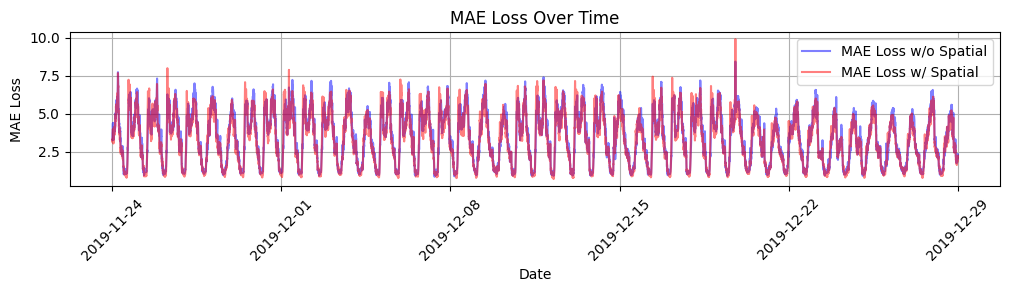

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming timesteps_06 and timesteps_07 correspond to 43 timesteps from 2019-11-19 to 2019-12-31
date_range = pd.date_range(start="2019-11-19", end="2019-12-31", freq="W")

# Plot the original and smoothed MAE values over time
plt.figure(figsize=(12, 2))
plt.plot(timesteps_06, mae_loss_per_timestep_06, label='MAE Loss w/o Spatial', color='blue', alpha=0.5)
plt.plot(timesteps_07, mae_loss_per_timestep_07, label='MAE Loss w/ Spatial', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('MAE Loss')
plt.title('MAE Loss Over Time')
plt.legend()
plt.grid(True)

# Proportionally adjust the x-axis ticks and labels
tick_positions = [int(x) for x in np.linspace(0, len(timesteps_06) - 1, len(date_range))]
tick_labels = date_range.strftime('%Y-%m-%d')

plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

plt.show()

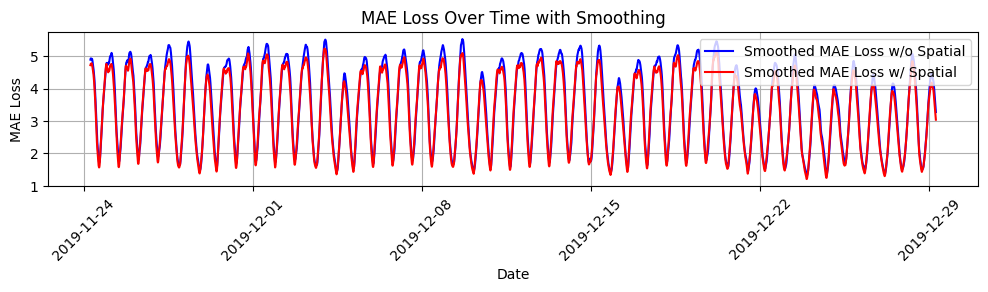

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming smoothed_timesteps_06 and smoothed_timesteps_07 correspond to a certain number of timesteps
# Generate date range from 2019-11-19 to 2019-12-31
date_range = pd.date_range(start="2019-11-19", end="2019-12-31", freq="W")

# Plot the original and smoothed MAE values over time
plt.figure(figsize=(12, 2))
plt.plot(smoothed_timesteps_06, smoothed_mae_06, label='Smoothed MAE Loss w/o Spatial', color='blue')
plt.plot(smoothed_timesteps_07, smoothed_mae_07, label='Smoothed MAE Loss w/ Spatial', color='red')
plt.xlabel('Date')
plt.ylabel('MAE Loss')
plt.title('MAE Loss Over Time with Smoothing')
plt.legend()
plt.grid(True)

# Proportionally adjust the x-axis ticks and labels
tick_positions = [int(x) for x in np.linspace(0, len(smoothed_timesteps_06) - 1, len(date_range))]
tick_labels = date_range.strftime('%Y-%m-%d')

plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

plt.show()